# Financial Fraud Detection Using PaySim Synthetic Dataset

#### FINAL PROJECT GSB-TRAINING 2025 [GSB X DIBIMBING.ID] 25 Oktober 2025
Disusun oleh:
Muhammad Khayruhanif | Panji Elang Permanajati | Izzat Khalil Yassin | Aisyah Syakira Aulia

PaySim menganalisis transaksi uang elektronik menggunakan data yang diperoleh dari catatan keuangan selama sebulan dari layanan uang elektronik yang beroperasi di negara Afrika. Catatan tersebut disediakan oleh perusahaan multinasional yang menyediakan layanan keuangan ini di lebih dari 14 negara di seluruh dunia.

## Import Data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer, log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

Sumber data: https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset/data

In [44]:
df = pd.read_csv('Synthetic_Financial_datasets_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**STRUKTUR DATASET**

- **step:** Merepresentasikan unit waktu di dunia nyata, dengan 1 langkah setara dengan 1 jam. Total simulasi mencakup 744 langkah, setara dengan 30 hari.
- **type:** Tipe transaksi meliputi CASH-IN (Setoran Tunai), CASH-OUT (Tarik Tunai), DEBIT, PAYMENT (Pembayaran), dan TRANSFER (Transfer).
- **amount:** Jumlah uang transaksi dalam mata uang lokal.
- **nameOrig:** Pelanggan yang memulai transaksi.
- **oldbalanceOrg:** Saldo pelanggan pengirim sebelum transaksi.
- **newbalanceOrig:** Saldo pelanggan pengirim setelah transaksi.
- **nameDest:** Pelanggan penerima transaksi.
- **oldbalanceDest:** Saldo awal penerima sebelum transaksi. Tidak berlaku untuk pelanggan yang diidentifikasi dengan 'M' (Merchant/Pedagang).
- **newbalanceDest:** Saldo baru penerima setelah transaksi. Tidak berlaku untuk 'M' (Merchant/Pedagang).
- **isFraud:** Mengidentifikasi transaksi yang dilakukan oleh agen penipuan yang bertujuan menguras akun pelanggan melalui transfer dan tarik tunai.
- **isFlaggedFraud:** Menandai transfer skala besar dan tidak sah antar akun, di mana setiap transaksi tunggal yang melebihi 200.000 dianggap ilegal.

## Exploratory Data Analysis

#### Informasi dari data

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Data berjumlah 6.362.620 dengan tipe data int64 berjumlah 3, float64 berjumlah 5, dan object berjumlah 3. Data akan dikategorikan menjadi data numerik (int64 dan float64) dan data kategorik (object).

In [91]:
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [50]:
numericals = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
kategoricals = ['type']

Menampilkan daftar nama kolom yang ada di dalam dataset. Output menunjukkan semua kolom aktif sehingga dapat diketahui variabel apa saja yang tersedia untuk dianalisis, kemudian kolom dipisahkan menjadi dua bagian yaitu bertipe data numerik dan kategorik.

In [52]:
df[kategoricals].describe()

,type
count,6362620
unique,5
top,CASH_OUT
freq,2237500


dari kolom **Type** memunculkan 5 data unik dengan modus yaitu CASH_OUT

In [54]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [56]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

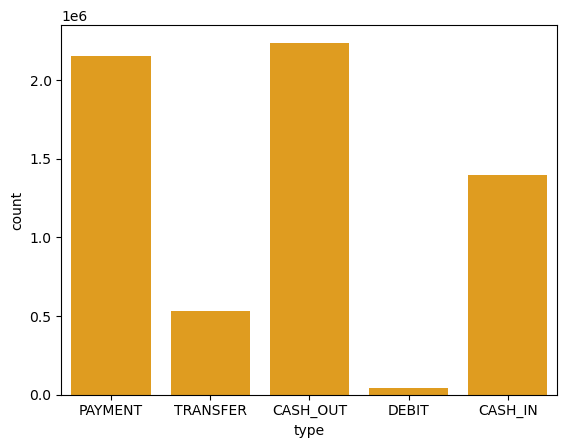

In [58]:
sns.countplot(data=df, x='type', color='orange')

Grafik count frekuensi lima kategori dalam kolom **Type**. Jarang orang yang menggunakan Debit dalam transaksi.

In [60]:
df[numericals].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


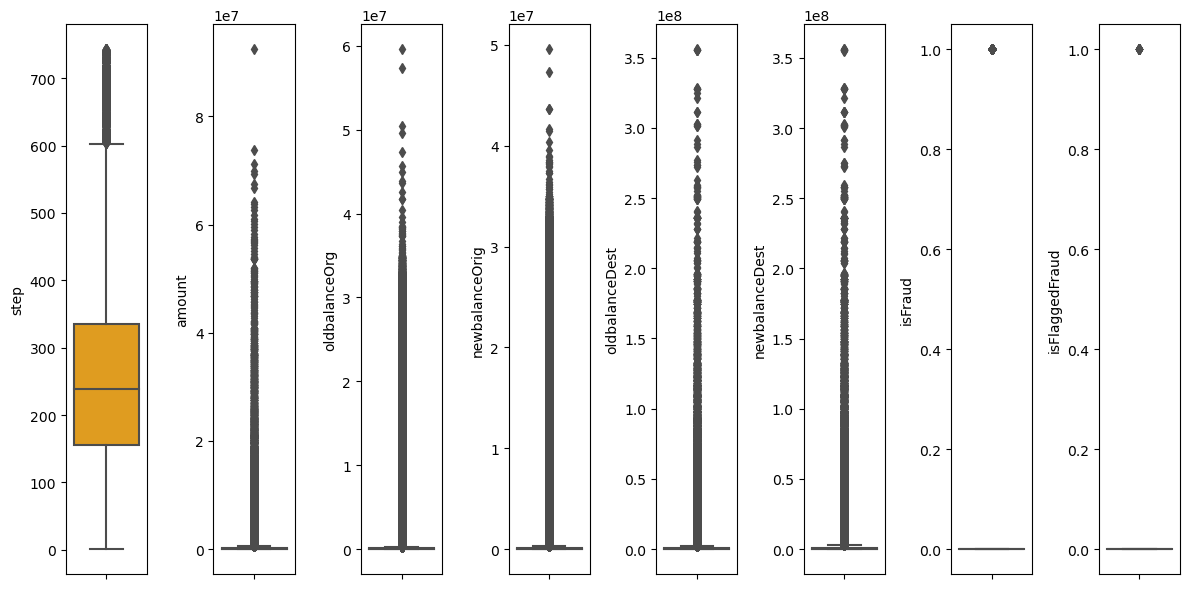

In [62]:
features = numericals
plt.figure(figsize=(12,6))

for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='orange')
    plt.tight_layout()

Data step memiliki bentuk box plot yang normal dan outlier yang terbilang sedikit dibandingkan data Amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest. Sedangkan data isFraud dan isFlaggedFraud merupakan data yang hanya memuat 0 atau 1, sehingga tidak berpengaruh apabila dilihat menggunakan box plot.

C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

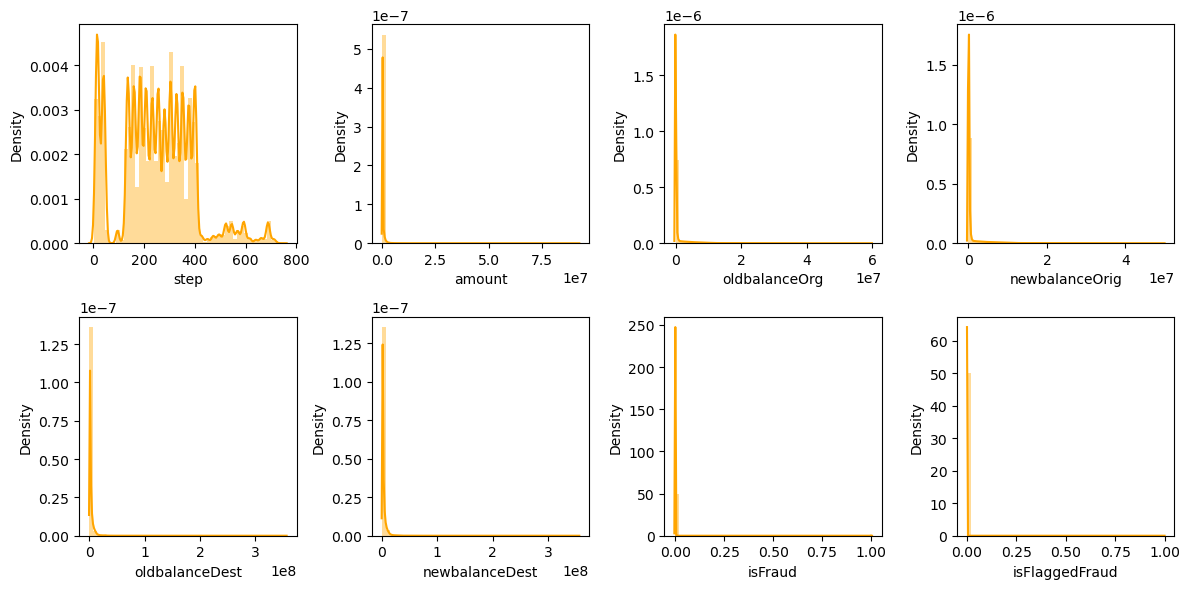

In [64]:
plt.figure(figsize=(12,6))

for i in range(0, len(features)):
    plt.subplot(2, 4, i+1)
    sns.distplot(x=df[features[i]], color='orange')
    plt.xlabel(features[i])
    plt.tight_layout()

Data Step memiliki sebaran binomial, sedangkan data lainnya selain isFraud dan isFlaggedFraud memiliki sebaran yang cukup ekstrim di sekitar 0, tetapi tetap memiliki outlier di sebarannya.

## Feature Engineering

In [66]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### Menghapus kolom yang tidak diperlukan

In [68]:
df = df.drop(columns=['nameOrig', 'nameDest'])
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


Kolom **nameOrig** dan **nameDest** dihapus karena hanya berisi identitas unik nasabah atau tujuan transaksi yang tidak berkontribusi langsung terhadap deteksi fraud. Dengan menghapus kolom yang tidak informatif ini, analisis menjadi lebih efisien, mengurangi kompleksitas model, dan membantu fokus pada variabel yang benar-benar memengaruhi aktivitas keuangan mencurigakan.

#### Memisahkan data dengan target

In [70]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


Memisahkan data dengan target agar mempermudah pemodelan. 

#### Encoding data

In [72]:
X['is_CASH_IN'] = X['type'].map({'CASH_IN':1, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':0})
X['is_PAYMENT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':1, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':0})
X['is_CASH_OUT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':1, 'TRANSFER':0, 'DEBIT':0})
X['is_TRANSFER'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':1, 'DEBIT':0})
X['is_DEBIT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':1})

X = X.drop(columns=['type'])

X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,is_CASH_IN,is_PAYMENT,is_CASH_OUT,is_TRANSFER,is_DEBIT
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0,0,0,1,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0


#### Mencari missing value

In [48]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Tidak ada data NaN sehingga tidak diperlukan pencegahan missing value.

Karena data bertipe kategorik hanya satu yaitu **Type**, perlu dilakukan encoding agar data bisa dilakukan pemodelan, dalam data ini terdapat lima kategori dan encoding dilakukan dengan membuat kelima kolom baru yang merepresentasikan masing2 kategori.

In [73]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

#### Memisahkan data train dengan data test

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

Memisahkan data training dengan data test agar proses feature engineering tidak meubah data test lebih jauh, hal ini dikarenakan data test harus bersifat apa adanya dan tidak boleh diubah agar data merepresentasikan hasil yang sebenarnya.

#### Duplikasi data

In [75]:
duplicates = df[df.duplicated()]

print("Menampilkan data duplikat:\n")
duplicates

Menampilkan data duplikat:



,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
11104,7,PAYMENT,1849.50,0.0,0.0,0.0,0.0,0,0
33556,8,PAYMENT,7759.31,0.0,0.0,0.0,0.0,0,0
59969,9,PAYMENT,2388.93,0.0,0.0,0.0,0.0,0,0
60763,9,PAYMENT,10042.85,0.0,0.0,0.0,0.0,0,0
63096,9,PAYMENT,2783.83,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
6281481,646,CASH_OUT,10000000.00,10000000.0,0.0,0.0,10000000.0,1,0
6281485,646,CASH_OUT,0.00,0.0,0.0,0.0,0.0,1,0
6351224,702,CASH_OUT,10000000.00,10000000.0,0.0,0.0,10000000.0,1,0
6362455,730,CASH_OUT,10000000.00,10000000.0,0.0,0.0,10000000.0,1,0


In [76]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,is_CASH_IN,is_PAYMENT,is_CASH_OUT,is_TRANSFER,is_DEBIT
6271196,619,386385.08,4669568.85,5055953.92,506035.06,119649.98,0,1,0,0,0,0
1888243,164,212458.78,234635.00,447093.78,806037.88,593579.10,0,1,0,0,0,0
5549957,382,19967.60,3634.00,0.00,0.00,0.00,0,0,1,0,0,0
2025342,180,527616.51,180216.00,0.00,92157.10,619773.61,0,0,0,1,0,0
682342,36,206067.85,0.00,0.00,2131494.48,2337562.32,0,0,0,0,1,0


## Modelling

### Menggunakan Logistic Regression

In [77]:
logreg = LogisticRegression(class_weight='balanced',random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

Menggunakan model Logistic Regression dalam mengklasifikasikan data fraud. Model cocok digunakan untuk data yang memiliki target berupa benar/salah seperti klasifikasi fraud. Penggunaan class weight ditujukan karena data yang dikategorikan fraud memiliki kuantitas yang sangat sedikit dibandingkan data yang bukan fraud, sehingga perlu disesuaikan agar data menjadi seimbang.

In [94]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model Logistic Regression: {accuracy:.2f}")

Akurasi model Logistic Regression: 0.91


Hasil prediksi dari model Logistic Regression diuji menggunakan data uji untuk menilai performanya. Nilai akurasi sebesar 0.91 menunjukkan bahwa model sangat baik dalam mengklasifikasikan transaksi. Namun, angka tinggi perlu diinterpretasikan hati2 karena data transaksi normal jauh lebih banyak dibanding transaksi fraud (data tidak seimbang). Dengan demikian, meskipun akurasinya terlihat hampir sempurna, perlu melihat metrik lain seperti precision, recall, dan confusion matrix untuk memastikan model benar-benar efektif dalam mendeteksi transaksi penipuan tanpa terlalu banyak kesalahan deteksi pada transaksi normal.

#### Akurasi dengan Log Loss

In [93]:
logloss_score = log_loss(y_test, y_proba)
print(f"Log loss: {logloss_score:.2f}")

Log loss: 0.33


metrik log loss digunakan untuk menilai seberapa baik model memprediksi probabilitas kelas. Nilai log loss sebesar 0.33 menunjukkan bahwa probabilitas yang diprediksi oleh model sangat mendekati nilai aktual artinya model tidak hanya tepat dalam klasifikasi tetapi juga percaya diri dan konsisten terhadap prediksinya. 

#### Akurasi dengan ROC AUC

In [92]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.96


Metrik ROC AUC digunakan untuk mengukur kemampuan model dalam membedakan transaksi yang fraud dan non-fraud. Nilai ROC AUC sebesar 0.96 menunjukkan bahwa model memiliki kinerja klasifikasi yang sangat baik mampu memisahkan kedua kelas dengan akurasi tinggi meskipun data fraud biasanya sangat tidak seimbang. Hal ini berarti sistem deteksi penipuan yang dikembangkan efektif dalam mengidentifikasi transaksi mencurigakan sehingga dapat meminimalkan potensi kerugian dan meningkatkan kepercayaan pelanggan terhadap keamanan layanan keuangan perusahaan.

#### Classification Report

In [86]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"Training Recall: {recall_train:.2f}")
print(f"Test Recall: {recall_test:.2f}\n")
print(classification_report(y_test, y_pred))

Training Recall: 0.90
Test Recall: 0.88

              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1270904
           1       0.01      0.88      0.02      1620

    accuracy                           0.91   1272524
   macro avg       0.51      0.90      0.49   1272524
weighted avg       1.00      0.91      0.95   1272524



Model Anda memiliki Recall yang sangat baik tetapi Precision yang sangat buruk pada kasus penipuan (Fraud). Namun, dari precision salah 0.99. Artinya, hanya 0.01 dari semua transaksi yang ditandai dan proses manual (dianggap fraud) yang benar-benar merupakan penipuan.

#### Confusion Matrix dari Logistic Regression

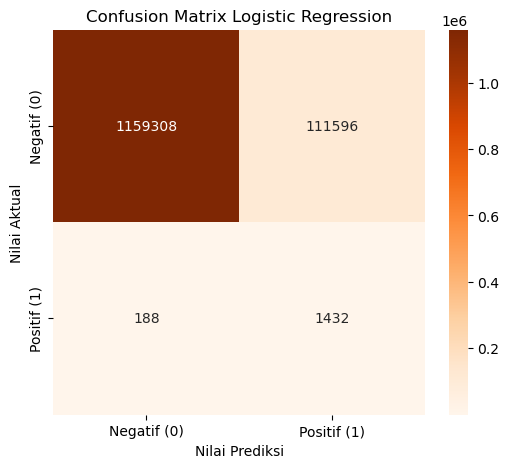

In [90]:
conmax = confusion_matrix(y_test, y_pred)

labels = ['Negatif (0)', 'Positif (1)']
plt.figure(figsize=(6,5))
sns.heatmap(conmax, annot=True, fmt='d',
            cmap='Oranges', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Nilai Prediksi')
plt.ylabel('Nilai Aktual')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

- **True Positives (TP)** ->	Model memprediksi Positif (1) dan hasilnya benar (Aktualnya Positif). Hasil yang Diinginkan
- **True Negatives (TN)** ->	Model memprediksi Negatif (0) dan hasilnya benar (Aktualnya Negatif). Hasil yang Diinginkan
- **False Positives (FP)** -> Model memprediksi Positif (1) tetapi hasilnya salah (Aktualnya Negatif). Kesalahan Tipe I (False Alarm)
- **False Negatives (FN)** -> Model memprediksi Negatif (0) tetapi hasilnya salah (Aktualnya Positif). Kesalahan Tipe II (Kasus Terlewat)

### Voting Classifier

Menggunakan voting classifier dengan tiga model yaitu Catboost, Random Forest Classifier, XGBoost dan dari hasilnya diinginkan berupa rataan untuk mendapatkan akurasi yang stabil dan kuat.

In [83]:
cat_clf = CatBoostClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

voting_clf = VotingClassifier(
    estimators=[('cat', cat_clf), ('rf', rf_clf), ('xgb', xgb_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

Learning rate set to 0.39419
0:	learn: 0.0591217	total: 794ms	remaining: 13m 13s
1:	learn: 0.0256981	total: 1.48s	remaining: 12m 19s
2:	learn: 0.0145212	total: 2.14s	remaining: 11m 51s
3:	learn: 0.0086502	total: 2.92s	remaining: 12m 6s
4:	learn: 0.0078461	total: 3.52s	remaining: 11m 39s
5:	learn: 0.0037813	total: 4.26s	remaining: 11m 46s
6:	learn: 0.0025895	total: 4.93s	remaining: 11m 40s
7:	learn: 0.0022002	total: 5.63s	remaining: 11m 38s
8:	learn: 0.0021000	total: 6.43s	remaining: 11m 47s
9:	learn: 0.0019510	total: 7.09s	remaining: 11m 41s
10:	learn: 0.0018388	total: 7.78s	remaining: 11m 39s
11:	learn: 0.0017434	total: 8.44s	remaining: 11m 35s
12:	learn: 0.0016917	total: 9.15s	remaining: 11m 34s
13:	learn: 0.0016744	total: 9.92s	remaining: 11m 38s
14:	learn: 0.0016273	total: 10.7s	remaining: 11m 40s
15:	learn: 0.0016182	total: 11.4s	remaining: 11m 38s
16:	learn: 0.0015720	total: 12.1s	remaining: 11m 37s
17:	learn: 0.0015437	total: 12.7s	remaining: 11m 33s
18:	learn: 0.0015152	total: 

C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:44:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000013494DA2970>),
                             ('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None,

In [89]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    # on training
    recall_train = recall_score(y_train, y_train_pred)
    # on testing dataset
    recall_test = recall_score(y_test, y_test_pred)

    print(f'Training Recall: {recall_train:.3f}')
    print(f'Test Recall: {recall_test:.3f}')
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True,        
        fmt='d',           
        cmap='Oranges',      
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel('Nilai Prediksi')
    plt.ylabel('Nilai Aktual')
    plt.title(f'Confusion Matrix Heatmap Voting Classifier')
    plt.show()

    return recall_train, recall_test

#### Akurasi voting Classifier dengan classification report dan confusion matrix

C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ASUS\Documents\Miniconda\envs\jcopml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training Recall: 0.954
Test Recall: 0.862

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.86      0.92      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.93      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



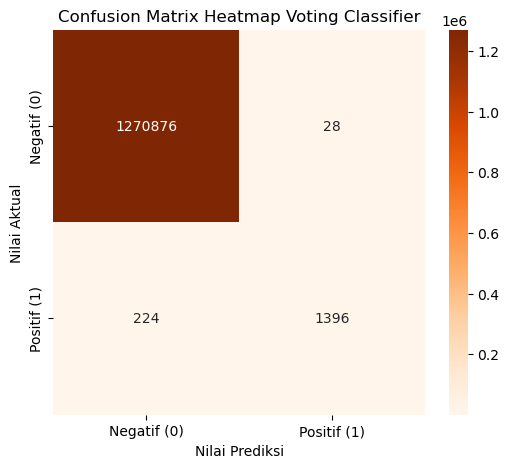

(0.9535871378735022, 0.8617283950617284)

<Figure size 640x480 with 0 Axes>

In [85]:
evaluate_model(voting_clf, X_train, y_train, X_test, y_test)

Model ensemble yang telah dioptimalkan berhasil menunjukkan kinerja yang baik dalam mendeteksi penipuan, ditandai dengan keseimbangan yang sangat baik antara sensitivitas penangkapan (Recall 0.86) dan akurasi prediksi positif (Precision 0.98) pada kasus fraud. 
- Model berhasil mendeteksi dan mencegah 86.2% dari semua kasus fraud yang sebenarnya. Kerugian finansial (False Negatives) diminimalisir secara signifikan.
- Ketika model fraud, ia benar 98% dari waktu tersebut. Biaya operasional untuk menyelidiki False Positives juga menjadi sangat rendah.
- Adanya penurunan Recall dari 0.954 (Training) menjadi 0.862 (Test) mengindikasikan bahwa model masih mengalami sedikit overfitting. Meskipun demikian, kinerja Test Recall 0.862 masih dianggap sangat baik dan stabil untuk penerapan selanjutnya.